In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import zipfile
import requests

# 1. Downloading EuroSAT Dataset  ---
def download_eurosat():
    url = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"
    filename = "EuroSAT.zip"

    if not os.path.exists(filename):
        print("EuroSAT downloading...")
        r = requests.get(url, verify=False)
        with open(filename, 'wb') as f:
            f.write(r.content)
        print("Download completed.")

        print("Folders are opening...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("./data")
        print("Ready!")
    else:
        print("Dataset is already downloaded.")

download_eurosat()

# EuroSAT images are in a folder named "2750" .
DATA_PATH = './data/2750'

# 2. Transformation of image sizes

# ResNet ImageNet waits a size of: 224x224, but EuroSAT images are in the size of: 64x64
# To do faster evaluation one can use 64x64.
# But for the sake of the Fine-Tuning success one can prefer to resize the images to 224.
# We'll stick with 64x64 here for the speed/performance balance (ResNet tolerates this).

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet standarts
])

# Download the dataset
full_dataset = ImageFolder(root=DATA_PATH, transform=transform)

# Total number of data points
total_count = len(full_dataset)

# %70 Train, %15 Val, %15 Test
train_size = int(0.7 * total_count)
val_size = int(0.15 * total_count)
test_size = total_count - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Total Images: {total_count}")
print(f"Training Set: {len(train_dataset)}")
print(f"Validation Set: {len(val_dataset)}")
print(f"Testing Set: {len(test_dataset)}")

# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Dataset is already downloaded.
Total Images: 27000
Training Set: 18900
Validation Set: 4050
Testing Set: 4050


Cihaz: cuda
Dataset is already downloaded.
Toplam Veri: 27000
Train: 18900 | Val: 4050 | Test: 4050
--- SCENARIO 1: Baseline ---

--- Baseline Training starts (Max 30 Epoch) ---
Epoch 1: Train Loss: 0.9286 | Val Loss: 0.7665
Epoch 2: Train Loss: 0.6352 | Val Loss: 0.7987
Epoch 3: Train Loss: 0.5185 | Val Loss: 1.0077
Epoch 4: Train Loss: 0.4542 | Val Loss: 1.0070
Epoch 5: Train Loss: 0.3840 | Val Loss: 0.6144
Epoch 6: Train Loss: 0.3212 | Val Loss: 0.6863
Epoch 7: Train Loss: 0.2916 | Val Loss: 0.4671
Epoch 8: Train Loss: 0.2368 | Val Loss: 1.8366
Epoch 9: Train Loss: 0.1921 | Val Loss: 0.4634
Epoch 10: Train Loss: 0.1692 | Val Loss: 0.3649
Epoch 11: Train Loss: 0.1372 | Val Loss: 0.3559
Epoch 12: Train Loss: 0.1237 | Val Loss: 1.1661
Epoch 13: Train Loss: 0.1014 | Val Loss: 0.6395
Epoch 14: Train Loss: 0.0875 | Val Loss: 3.4171
Epoch 15: Train Loss: 0.0860 | Val Loss: 0.6727
Epoch 16: Train Loss: 0.0692 | Val Loss: 0.4360
!!! Early Stopping Triggered. Stopped at Epoch 16.
Baseline Com

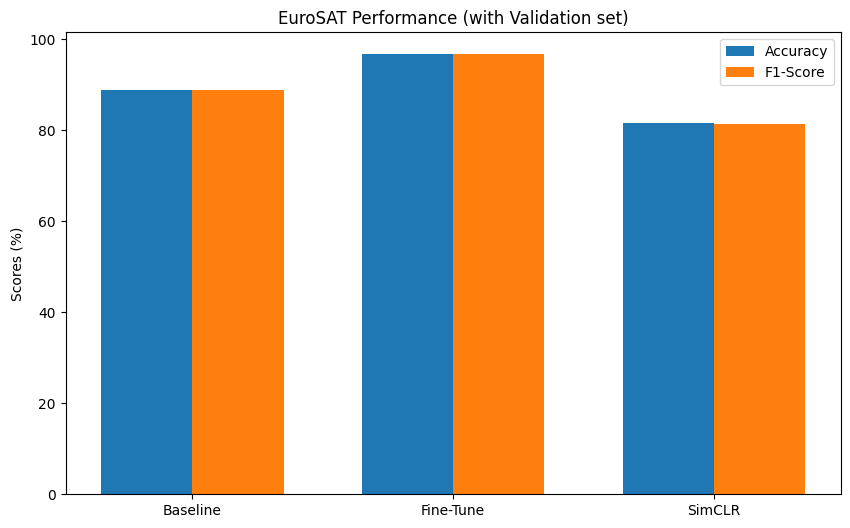

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os
import requests
import zipfile

# 1. Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

# Hyperparameters
BATCH_SIZE = 128
MAX_EPOCHS = 30       # Maximum limit for Supervised training
SIMCLR_EPOCHS = 30    # SimCLR pre-training duration
PATIENCE = 5          # Early Stopping patience

# 2. Downloading and preparing dataset
def download_eurosat():
    url = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"
    filename = "EuroSAT.zip"
    if not os.path.exists(filename):
        print("EuroSAT downloading...")
        r = requests.get(url, verify=False)
        with open(filename, 'wb') as f:
            f.write(r.content)
        print("Download completed.")

        print("Folders are opening...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("./data")
        print("Ready!")
    else:
        print("Dataset is already downloaded.")

download_eurosat()
DATA_PATH = './data/2750'

# Transforming (64x64)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# %70 Train, %15 Val, %15 Test
full_dataset = ImageFolder(root=DATA_PATH, transform=transform)
total_count = len(full_dataset)
train_size = int(0.7 * total_count)
val_size = int(0.15 * total_count)
test_size = total_count - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Toplam Veri: {total_count}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 3. EARLY STOPPING Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

    def load_best_weights(self, model):
        model.load_state_dict(self.best_model_wts)

# 4. Training Function (TRAIN / VAL / TEST)
def train_with_validation(model, train_loader, val_loader, test_loader, optimizer, criterion, max_epochs, name):
    model.to(device)
    train_losses = []
    val_losses = []

    early_stopper = EarlyStopping(patience=PATIENCE, min_delta=0.001)

    print(f"\n--- {name} Training starts (Max {max_epochs} Epoch) ---")
    start_time = time.time()

    for epoch in range(max_epochs):
        # TRAINING
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # VALIDATION (Decision-making mechanism)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early Stopping Control
        early_stopper(epoch_val_loss, model)
        if early_stopper.early_stop:
            print(f"!!! Early Stopping Triggered. Stopped at Epoch {epoch+1}.")
            break

    # Load the best weights
    early_stopper.load_best_weights(model)
    print(f"{name} Completed. Duration: {time.time()-start_time:.1f}sec.")

    # FINAL TEST (Only for reporting)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_acc = accuracy_score(all_labels, all_preds) * 100
    final_f1 = f1_score(all_labels, all_preds, average='weighted') * 100

    return final_acc, final_f1, train_losses, val_losses

# SCENARIO 1: BASELINE (TRAINING FROM SCRATCH)

criterion = nn.CrossEntropyLoss()
print("--- SCENARIO 1: Baseline ---")
model_scratch = resnet18(weights=None)
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, 10)
optimizer_scr = optim.Adam(model_scratch.parameters(), lr=1e-3)

acc_scr, f1_scr, _, _ = train_with_validation(
    model_scratch, train_loader, val_loader, test_loader, optimizer_scr, criterion, MAX_EPOCHS, "Baseline"
)

# SCENARIO 2: FINE-TUNING (TRANSFER LEARNING)

print("--- SCENARIO 2: Fine-Tuning ---")
model_ft = resnet18(weights=ResNet18_Weights.DEFAULT)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)

acc_ft, f1_ft, _, _ = train_with_validation(
    model_ft, train_loader, val_loader, test_loader, optimizer_ft, criterion, MAX_EPOCHS, "Fine-Tuning"
)

# SCENARIO 3: SIMCLR (SSL)

print("--- SCENARIO 3: SimCLR ---")

class SimCLRTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(64, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    def __call__(self, x):
        return self.transform(x), self.transform(x)

# SimCLR Wrapper (Fix for the subset issue.)
class SimCLRSubsetWrapper(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.transform = SimCLRTransform()
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        original_idx = self.subset.indices[idx]
        original_dataset = self.subset.dataset
        path, _ = original_dataset.samples[original_idx]
        img = original_dataset.loader(path)
        return self.transform(img), 0

simclr_dataset = SimCLRSubsetWrapper(train_dataset)
simclr_loader = DataLoader(simclr_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)

class SimCLR(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.encoder = base_model
        self.encoder.fc = nn.Identity()
        self.projector = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 64))
    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return h, z

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0)
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / self.temperature
        mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=torch.bool, device=device)).float()
        sim_ij = torch.diag(sim, batch_size)
        sim_ji = torch.diag(sim, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        nominator = torch.exp(positives)
        denominator = mask * torch.exp(sim)
        loss = -torch.log(nominator / torch.sum(denominator, dim=1))
        return torch.mean(loss)

model_simclr_base = resnet18(weights=None)
model_simclr = SimCLR(model_simclr_base).to(device)
optimizer_simclr = optim.Adam(model_simclr.parameters(), lr=1e-3)
criterion_simclr = NTXentLoss()

print(f"--- SimCLR Pre-Training Starts ({SIMCLR_EPOCHS} Epoch) ---")
for epoch in range(SIMCLR_EPOCHS):
    model_simclr.train()
    total_loss = 0
    for (xi, xj), _ in simclr_loader:
        xi, xj = xi.to(device), xj.to(device)
        optimizer_simclr.zero_grad()
        _, zi = model_simclr(xi)
        _, zj = model_simclr(xj)
        loss = criterion_simclr(zi, zj)
        loss.backward()
        optimizer_simclr.step()
        total_loss += loss.item()
    if (epoch+1) % 5 == 0:
        print(f"SimCLR Epoch {epoch+1}/{SIMCLR_EPOCHS} Loss: {total_loss/len(simclr_loader):.4f}")

# SimCLR Linear Eval
print("\n--- SimCLR Linear Evaluation Starts ---")
frozen_encoder = model_simclr.encoder
for param in frozen_encoder.parameters():
    param.requires_grad = False

class LinearEval(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(512, 10)
    def forward(self, x):
        return self.fc(self.encoder(x))

model_ssl_eval = LinearEval(frozen_encoder)
optimizer_ssl = optim.Adam(model_ssl_eval.fc.parameters(), lr=1e-3)

acc_ssl, f1_ssl, _, _ = train_with_validation(
    model_ssl_eval, train_loader, val_loader, test_loader, optimizer_ssl, criterion, MAX_EPOCHS, "SimCLR Linear Eval"
)

# PRINTING AND DRAWING THE RESULTS
print("\n" + "="*50)
print(f"{'Method':<20} | {'Accuracy':<10} | {'F1-Score':<10}")
print("-" * 50)
print(f"{'Fine-Tuning':<20} | %{acc_ft:<9.2f} | %{f1_ft:<9.2f}")
print(f"{'Baseline':<20} | %{acc_scr:<9.2f} | %{f1_scr:<9.2f}")
print(f"{'SimCLR (SSL)':<20} | %{acc_ssl:<9.2f} | %{f1_ssl:<9.2f}")
print("="*50)

labels = ['Baseline', 'Fine-Tune', 'SimCLR']
acc_scores = [acc_scr, acc_ft, acc_ssl]
f1_scores = [f1_scr, f1_ft, f1_ssl]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, acc_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score')
ax.set_ylabel('Scores (%)')
ax.set_title('EuroSAT Performance (with Validation set)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()